In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

sns.set_style(style="ticks")
sns.set_palette(sns.color_palette("Dark2"))

from os.path import isfile

In [2]:
exclude_lines = [i for i, line in enumerate(open('./data/src/cleve.mod')) if line.startswith('%')]

src_cleve_df = pd.read_csv(
    filepath_or_buffer='./data/src/cleve.mod',
    delimiter=' ',
    names=[
        'age', 
        'sex', 
        'cp',
        'trestbps',
        'chol',
        'fbs',
        'restecg',
        'thalach',
        'exang',
        'oldpeak',
        'slope',
        'ca',
        'thal',
        'healthy',
        'health_state'
    ],
    skiprows=exclude_lines,
    skipinitialspace=True,
    na_values=['?', -9]
)

In [3]:
src_cleve_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,healthy,health_state
0,63.0,male,angina,145.0,233.0,true,hyp,150.0,fal,2.3,down,0.0,fix,buff,H
1,67.0,male,asympt,160.0,286.0,fal,hyp,108.0,true,1.5,flat,3.0,norm,sick,S2
2,67.0,male,asympt,120.0,229.0,fal,hyp,129.0,true,2.6,flat,2.0,rev,sick,S1
3,37.0,male,notang,130.0,250.0,fal,norm,187.0,fal,3.5,down,0.0,norm,buff,H
4,41.0,fem,abnang,130.0,204.0,fal,hyp,172.0,fal,1.4,up,0.0,norm,buff,H


In [4]:
src_cleve_df.isna().sum()

age             0
sex             0
cp              0
trestbps        0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              5
thal            2
healthy         0
health_state    0
dtype: int64

In [5]:
src_cleve_df.shape

(303, 15)

In [6]:
sex = {
    'male': 1,
    'fem':  0
}

# chest pain type
cp = {
    'angina': 1, #typical angina
    'abnang': 2, #atypical angina 
    'notang': 3, #non-anginal pain
    'asympt': 4  #asymptomatic
}

#fasting blood sugar > 120 mg/dl
fbs = {
    'fal':  0,
    'true': 1
}

#resting electrocardiographic results
restecg = {
    'norm': 0, #normal
    'abn':  1, #having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    'hyp':  2  #showing probable or definite left ventricular hypertrophy by Estes' criteria
}

#exercise induced angina (1 = yes; 0 = no)
exang = {
    'fal':  0,
    'true': 1    
}
#the slope of the peak exercise ST segment
slope = {
    'up':   1,
    'flat': 2,
    'down': 3
}


thal = {
    'norm': 3, #normal
    'fix':  6, #fixed defect
    'rev':  7  #reversable defect
}
        
healthy = {
    'buff': 0,
    'sick': 1
}

health_state = {
    'H':  0,
    'S1': 1,
    'S2': 2,
    'S3': 3,
    'S4': 4,
}

In [7]:
X = pd.DataFrame()

X['age'] = src_cleve_df.dropna()['age']
X['sex'] = [sex[x] for x in src_cleve_df.dropna()['sex']]
X['cp'] = [cp[x] for x in src_cleve_df.dropna()['cp']]
X['trestbps'] = src_cleve_df.dropna()['trestbps']
X['chol'] = src_cleve_df.dropna()['chol']
X['fbs'] = [fbs[x] for x in src_cleve_df.dropna()['fbs']]
X['restecg'] = [restecg[x] for x in src_cleve_df.dropna()['restecg']]
X['exang'] = [exang[x] for x in src_cleve_df.dropna()['exang']]
X['oldpeak'] = src_cleve_df.dropna()['oldpeak']
X['slope'] = [slope[x] for x in src_cleve_df.dropna()['slope']]
X['ca'] = src_cleve_df.dropna()['ca']
X['thal'] = [thal[x] for x in src_cleve_df.dropna()['thal']]

y = np.array(
    [healthy[x] for x in src_cleve_df.dropna()['healthy']]
)

X['healthy'] = y

In [8]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,exang,oldpeak,slope,ca,thal,healthy
0,63.0,1,1,145.0,233.0,1,2,0,2.3,3,0.0,6,0
1,67.0,1,4,160.0,286.0,0,2,1,1.5,2,3.0,3,1
2,67.0,1,4,120.0,229.0,0,2,1,2.6,2,2.0,7,1
3,37.0,1,3,130.0,250.0,0,0,0,3.5,3,0.0,3,0
4,41.0,0,2,130.0,204.0,0,2,0,1.4,1,0.0,3,0


In [9]:
print(y)

[0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0
 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1
 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0
 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0
 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0
 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0]


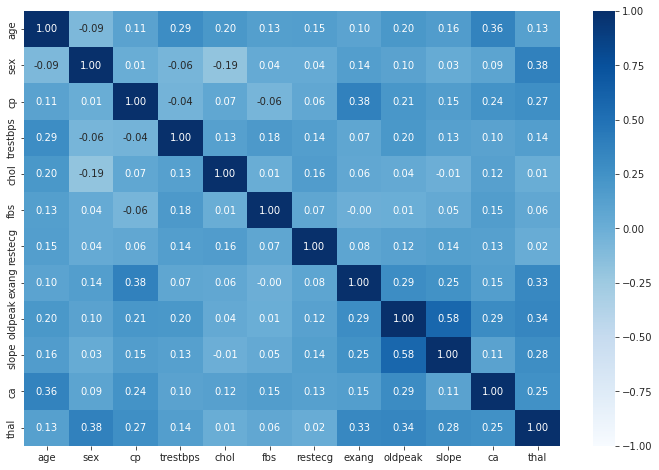

In [10]:
f, ax = plt.subplots(figsize=(12, 8))
a = sns.heatmap(data=X.loc[:, X.columns != 'healthy'].corr(), annot=True, fmt=".2f", cmap='Blues', vmin=-1.0, vmax=1.0, center=0.0)

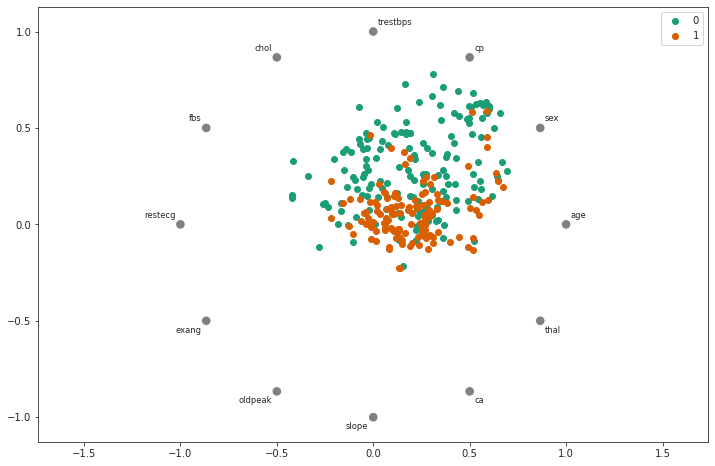

In [11]:
f, ax = plt.subplots(figsize=(12, 8))
a = pd.plotting.radviz(frame=X, class_column='healthy', color=sns.color_palette())

In [12]:
X_ = X.drop(['healthy'], axis=1)
y_ = y

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, shuffle=True, stratify=y_, random_state=42)

In [13]:
svm_result = None

if isfile("./data/models/model_svm.pkl"):
    with open("./data/models/model_svm.pkl", "rb") as m_file:
        svm_result = pickle.load(m_file)
else:
    model_svm = SVC(decision_function_shape='ovo')#, probability=True)
    
    c_values = np.arange(1, 100, 1)
    gamma_p = ['scale', 'auto']
    degree_p = np.arange(1, 10, 1)
    coef0_p = np.arange(0, 1, 0.1)
    
    params = [
        {'kernel': ['linear'], 'C': c_values},
        {'kernel': ['poly'], 'C': c_values, 'degree': degree_p, 'gamma': gamma_p, 'coef0': coef0_p},
        {'kernel': ['rbf'], 'C': c_values, 'gamma': gamma_p},
        {'kernel': ['sigmoid'], 'C': c_values, 'gamma': gamma_p, 'coef0': coef0_p}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_svm, param_grid=params, n_jobs=-1, cv=cross_val, scoring='accuracy', error_score=0)
    svm_result = grid_search.fit(X_train, y_train)
    
    with open("./data/models/model_svm.pkl", "wb") as m_file:
        pickle.dump(svm_result, m_file)

KeyboardInterrupt: 

In [ ]:
n_class = 2

fp_svc, tp_svc, thr_svc = {}, {}, {}

predict_svc = svm_result.best_estimator_.predict_proba(X_test)

for i in range(n_class):
    fp_svc[i], tp_svc[i], thr_svc[i] = roc_curve(y_test, predict_svc[:,i], pos_label=i)

print('AUC for SVC :\t{:.4f}'.format(roc_auc_score(y_test, predict_svc, multi_class='ovo')))
print("\nModels hyperparameters are: {}".format(svm_result.best_params_))

In [ ]:
colors = {
    0: 'orange',
    1: 'green',
}

labels = {
    0: 'Healthy',
    1: 'Sick',
}

plt.subplots(1, figsize=(5, 5))
plt.title('ROC for SVC')

for i in range(n_class):
    plt.plot(fp_svc[i], tp_svc[i], linestyle='--',color=colors[i], label=labels[i])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()